In [ ]:
import sys
import os
import numpy as np
from astropy.table import QTable, Table, vstack
import fnmatch
import matplotlib.pyplot as plt
from scipy.integrate import simps
import pickle 
import glob
import time,math
import clmm
import GCRCatalogs
from GCR import GCRQuery
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import iminuit
from iminuit import Minuit
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import mysql
from mysql.connector import Error
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Data

## Load dc2dr6 data

In [15]:
object_basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                           # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Error code returned by shape measurement code
    GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')), # Shape measurement uncertainty should not be NaN
    ]

object_properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 25'),                                 # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.4'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    # New cut on blendedness:
    GCRQuery('blendedness < 10**(-0.375)'),                      # Avoid spurious detections and those contaminated by blends
    GCRQuery('photoz_mean > 0.3'),
    GCRQuery('photoz_mean < 1')
    ]

In [16]:
quantity_label = ['id', 'ra', 'dec', 'mag_i_cModel','snr_i_cModel', 'mag_i']
quantity_wanted_HSM = ['ext_shapeHSM_HsmShapeRegauss_e2',
                       'ext_shapeHSM_HsmShapeRegauss_e1',
                       'ext_shapeHSM_HsmShapeRegauss_sigma', 
                       'ext_shapeHSM_HsmShapeRegauss_resolution',
                      'mcal_g1', 'mcal_g2', 'mcal_gauss_g1','mcal_gauss_g1', 'mcal_psf_g1', 'mcal_psf_g2']
quantity_wanted_photozs = ['photoz_mean']

In [17]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons')

In [18]:
object_data = object_cat.get_quantities(quantity_label + quantity_wanted_HSM + quantity_wanted_photozs, filters=(object_basic_cuts + object_properties_cuts),
                                                    native_filters = ['tract == 4852'])

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [19]:
cl_dc2 = Table(object_data)

## Load cosmoDC2 data

In [20]:
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040) 
cursor = conn.cursor(dictionary=True, buffered=True) 
zmin = 0.3 #Msun
zmax = 1
ra = np.mean(cl_dc2['ra'])
dec = np.mean(cl_dc2['dec'])
query = "SELECT data.coord_ra as ra_cosmodc2, data.coord_dec as dec_cosmodc2, data.redshift as z_cosmodc2, "
query += "data.mag_i, data.mag_r, data.mag_y, data.galaxy_id as dc2_galaxy_id, "
query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
query += "data.ellipticity_1_true as e1_true, data.ellipticity_2_true as e2_true " 
query += "FROM cosmoDC2_v1_1_4_image.data as data "
query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {1}) = 1 "
query += f"AND data.mag_i <= 25 "
query += ";"
t0 = time.time()
cl_cosmodc2 = pd.read_sql_query(query,conn)
tf = time.time()

In [21]:
cl_cosmodc2 = QTable.from_pandas(cl_cosmodc2)

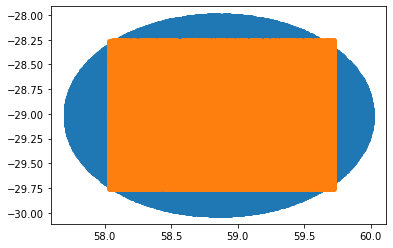

In [28]:
plt.scatter(cl_cosmodc2['ra_cosmodc2'], cl_cosmodc2['dec_cosmodc2'])
plt.scatter(cl_dc2['ra'], cl_dc2['dec'])

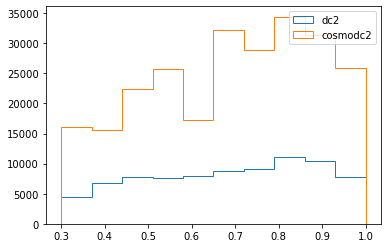

In [30]:
plt.hist(cl_dc2['photoz_mean'], histtype= 'step', align='mid', density = False, label = 'dc2')
plt.hist(cl_cosmodc2['z_cosmodc2'], histtype= 'step', align='mid', density = False, label = 'cosmodc2')
plt.legend()
plt.show()

In [31]:
cosmodc2 = SkyCoord(ra=np.array(cl_cosmodc2['ra_cosmodc2'])*u.deg, dec=np.array(cl_cosmodc2['dec_cosmodc2'])*u.deg, distance = cosmo_astropy.angular_diameter_distance(cl_cosmodc2['z_cosmodc2']))
dc2 = SkyCoord(ra=np.array(cl_dc2['ra'])*u.deg, dec=np.array(cl_dc2['dec'])*u.deg, distance =cosmo_astropy.angular_diameter_distance(cl_dc2['photoz_mean']))

In [32]:
print(len(cosmodc2)), print(len(dc2))

249671
81844


(None, None)

In [33]:
idx, sep2d, sep3d = match_coordinates_sky(dc2, cosmodc2, nthneighbor=1)
sep2d = Angle(sep2d, unit = u.deg)
dc2_match = cl_dc2
cosmodc2_match = cl_cosmodc2[idx]
print(len(cosmodc2_match)), print(len(dc2_match))

81844
81844


(None, None)

In [34]:
sep2d_ = Angle(sep2d, u.arcsec)

In [35]:
sep2d_.value

array([8.43233256e+00, 3.15159277e+01, 5.05799594e+00, ...,
       2.51060314e-03, 3.21469822e+00, 4.31699013e+00])

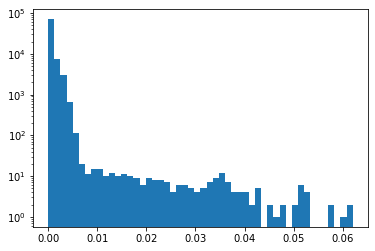

In [36]:
plt.hist(sep2d.value, bins = 50)
plt.yscale('log')

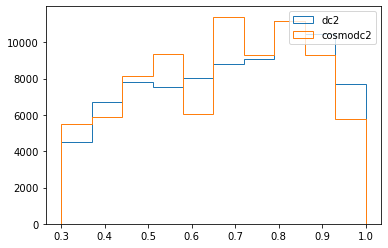

In [37]:
plt.hist(dc2_match['photoz_mean'], histtype= 'step', align='mid', density = False, label = 'dc2')
plt.hist(cosmodc2_match['z_cosmodc2'], histtype= 'step', align='mid', density = False, label = 'cosmodc2')
plt.legend()
plt.show()

In [38]:
t = hstack([cosmodc2_match, dc2_match])
mask = (sep2d.value < 0.001)
t = t[mask]
data = clmm.GCData(t)
cl = clmm.GalaxyCluster('Stack', ra, dec, 0, data)
cl.galcat['e1_cosmodc2'], cl.galcat['e2_cosmodc2'] = clmm.utils.compute_lensed_ellipticity(cl.galcat['e1_true'], cl.galcat['e2_true'], cl.galcat['shear1'], cl.galcat['shear2'], cl.galcat['kappa'])
print(cl.ra), print(cl.dec)

58.85776320152817
-29.011472415319673


(None, None)

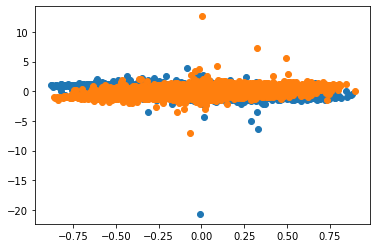

In [39]:
plt.scatter(cl.galcat['e1_cosmodc2'], cl.galcat['ext_shapeHSM_HsmShapeRegauss_e1'])
plt.scatter(cl.galcat['e2_cosmodc2'], cl.galcat['ext_shapeHSM_HsmShapeRegauss_e2'])

(-1.0, 1.0)

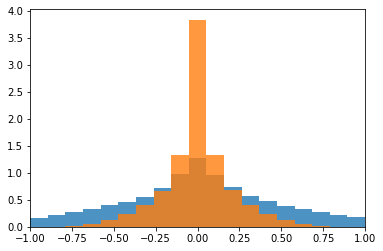

In [55]:
plt.hist(cl.galcat['ext_shapeHSM_HsmShapeRegauss_e1']/0.8,bins = np.linspace(-1, 1, 20), density = True, alpha = .8)
plt.hist(cl.galcat['e1_cosmodc2'], bins = np.linspace(-1, 1, 20), density = True, alpha = .8)
#plt.yscale('log')
plt.xlim(-1,1)

In [40]:
cl.galcat['mcal_g2_'] = - cl.galcat['mcal_g2']
cl.galcat['ext_shapeHSM_HsmShapeRegauss_e1_'] = - cl.galcat['ext_shapeHSM_HsmShapeRegauss_e1']

In [41]:
cl.compute_tangential_and_cross_components(geometry="flat", shape_component1 =  'mcal_g1', shape_component2 = 'mcal_g2_', tan_component = 'et_cal', cross_component = 'ex_cal',  is_deltasigma = False)
cl.compute_tangential_and_cross_components(geometry="flat", shape_component1 =  'ext_shapeHSM_HsmShapeRegauss_e1_', shape_component2 = 'ext_shapeHSM_HsmShapeRegauss_e2', tan_component = 'et_HSM', cross_component = 'ex_HSM',  is_deltasigma = False)
cl.compute_tangential_and_cross_components(geometry="flat", shape_component1 =  'e1_cosmodc2', shape_component2 = 'e2_cosmodc2', tan_component = 'et_cosmodc2', cross_component = 'ex_cosmodc2',  is_deltasigma = False)

/pbs/throng/lsst/users/cpayerne/CLMM/clmm/dataops/__init__.py:410: UserWarning: Using the flat-sky approximation with separations >1 deg may be inaccurate
  "Using the flat-sky approximation with separations >1 deg may be inaccurate")


(array([0.01735052, 0.01619745, 0.01698845, ..., 0.01618621, 0.01725866,
        0.01724202]),
 array([-0.40564968, -0.15469716, -0.1583313 , ..., -0.013955  ,
         0.03286362,  0.00652226]),
 array([-0.29540499, -0.27197325,  0.00250669, ..., -0.13348536,
         0.0024426 ,  0.00632683]))

In [ ]:
from iminuit import Minuit

## HSM calibration

In [ ]:
mask = cl.galcat['ext_shapeHSM_HsmShapeRegauss_sigma'] < .1
edges = np.linspace(-.7,.7, 11)
bins = [[edges[i], edges[i+1]] for i in range(len(edges)-1)]
et_mean_cosmodc2 = []
et_mean_HSM = []
et_std_cosmodc2 = []
et_std_HSM = []
n = []
for i, b in enumerate(bins):
    masks = (cl.galcat['et_cosmodc2'][mask] > b[0])*(cl.galcat['et_cosmodc2'][mask] < b[1])
    n_ = len(masks[masks== True])
    et_mean_cosmodc2.append(np.mean(cl.galcat['et_cosmodc2'][mask][masks]))
    et_std_cosmodc2.append(np.std(cl.galcat['et_cosmodc2'][mask][masks]))
    et_mean_HSM.append(np.mean(cl.galcat['et_HSM'][mask][masks]/2))
    et_std_HSM.append(np.std(cl.galcat['et_HSM'][mask][masks]/2))
    n.append(n_)

In [ ]:
def chi2(a, b, c, k):
    x = np.array(et_mean_cosmodc2)
    model = k + a*x + b*x**2 + c*x**3
    return np.sum(np.array(n)*(model - np.array(et_mean_HSM))**2/(np.array(et_std_HSM)**2))
minuit_linear = Minuit(chi2, a = 1, b = 0, c = 0, k = 0, errordef = .5, fix_b = True, fix_c =True)
minuit_linear.migrad(),minuit_linear.hesse(),minuit_linear.minos()
minuit_cubic = Minuit(chi2, a = 1, b = 0, c = 0, k = 0, errordef = .5, fix_b = True, fix_c =False)
minuit_cubic.migrad(),minuit_cubic.hesse(),minuit_cubic.minos()
a = 1

In [ ]:
minuit_linear.values['a']

In [ ]:
# Basic 2D density plot
plt.figure(figsize = (5,5))
l = .8
x = np.linspace(-l,l, 100)
model_linear = minuit_linear.values['k'] + minuit_linear.values['a']*x + minuit_linear.values['b']*x**2 + minuit_linear.values['c']*x**3
model_cubic = minuit_cubic.values['k'] + minuit_cubic.values['a']*x + minuit_cubic.values['b']*x**2 + minuit_cubic.values['c']*x**3
plt.plot(x, model_linear, '--b', linewidth = 3, label = r'best fit $ax + b$')
plt.plot(x, model_cubic, '--g', linewidth = 3, label = r'best fit $ax + bx^3 + c$')
plt.errorbar(et_mean_cosmodc2, et_mean_HSM, et_std_HSM,  et_std_cosmodc2, 
             elinewidth=3,
             fmt = ' ', color = 'r', zorder = 100, capsize = 0)
plt.scatter(cl.galcat['et_cosmodc2'][mask], cl.galcat['et_HSM'][mask]/2, alpha = .01, color = 'c', 
            linewidth=5)
plt.plot(x, x, '-k', linewidth = 3, label = 'x=y')
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.legend(loc='upper left', frameon = False, fontsize = 14, numpoints = 1)
plt.xlim(-l,l)
plt.ylim(-l,l)
plt.xlabel(r'$\epsilon_{\rm t, cosmoDC2}$', fontsize = 30)
plt.ylabel(r'$\epsilon_{\rm t, HSM}$', fontsize = 30)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/calibration_HSM.png', bbox_inches='tight', dpi=300)

## Metacal calbration

In [ ]:
def chi2(a, b, c, k):
    x = np.array(et_mean_cosmodc2)
    model = k + a*x + b*x**2 + c*x**3
    return np.sum(np.array(n)*(model - np.array(et_mean_cal))**2/(np.array(et_std_cal)**2))
minuit_linear = Minuit(chi2, a = 1, b = 0, c = 0, k = 0, errordef = .5, fix_b = True, fix_c =True)
minuit_linear.migrad(),minuit_linear.hesse(),minuit_linear.minos()
minuit_cubic = Minuit(chi2, a = 1, b = 0, c = 0, k = 0, errordef = .5, fix_b = True, fix_c =False)
minuit_cubic.migrad(),minuit_cubic.hesse(),minuit_cubic.minos()
a = 1

In [ ]:
minuit_linear.values['a']

In [ ]:
# Basic 2D density plot
plt.figure(figsize = (5,5))
l = .8
x = np.linspace(-l,l, 100)
model_linear = minuit_linear.values['k'] + minuit_linear.values['a']*x + minuit_linear.values['b']*x**2 + minuit_linear.values['c']*x**3
model_cubic = minuit_cubic.values['k'] + minuit_cubic.values['a']*x + minuit_cubic.values['b']*x**2 + minuit_cubic.values['c']*x**3
plt.plot(x, model_linear, '--b', linewidth = 3, label = r'best fit $ax + b$')
plt.plot(x, model_cubic, '--g', linewidth = 3, label = r'best fit $ax + bx^3 + c$')
plt.errorbar(et_mean_cosmodc2, et_mean_cal, et_std_cal,  et_std_cosmodc2, 
             elinewidth=3,
             fmt = ' ', color = 'r', zorder = 100, capsize = 0)
plt.scatter(cl.galcat['et_cosmodc2'][mask], cl.galcat['et_cal'][mask], alpha = .01, color = 'c', 
            linewidth=5)
plt.plot(x, x, '-k', linewidth = 3, label = 'x=y')
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.legend(loc='upper left', frameon = False, fontsize = 14, numpoints = 1)
plt.xlim(-l,l)
plt.ylim(-l,l)
plt.xlabel(r'$\epsilon_{\rm t, cosmoDC2}$', fontsize = 30)
plt.ylabel(r'$\epsilon_{\rm t, mcal}$', fontsize = 30)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/calibration_METACAL.png', bbox_inches='tight', dpi=300)